<a href="https://colab.research.google.com/github/samaco634/deep-learning-basics/blob/main/%5B%EB%94%A5%EB%9F%AC%EB%8B%9D%EA%B8%B0%EC%B4%88_03_1%5D%EC%86%90%EA%B8%80%EC%94%A8_%EC%9D%B8%EC%8B%9D_MNIST_in_Keras(CNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline

# Introduction to Deep Learning with Keras and TensorFlow

**Daniel Moser (UT Southwestern Medical Center)**

**Resources: [Xavier Snelgrove](https://github.com/wxs/keras-mnist-tutorial), [Yash Katariya](https://github.com/yashk2810/MNIST-Keras)**

딥 러닝의 기본 사항을 이해하는 데 도움이 되도록 이 데모에서는 정확도가 95%를 초과하는 손글씨 숫자를 분류하기 위한 CNN을 소개합니다. CNN은컨볼루션과 풀링의 개념을 도입한 심층 네트워크입니다.

## AI를 위한 과제

우리의 목표는 수천 개의 손으로 쓴 숫자 이미지에 인공 신경망을 구성하고 훈련시켜 제시될 때 다른 사람을 성공적으로 식별할 수 있도록 하는 것입니다. 통합될 데이터는 훈련용 이미지 60,000개와 테스트 이미지 10,000개가 포함된 MNIST 데이터베이스입니다. TensorFlow를 백엔드로 사용하는 Keras Python API를 사용합니다.

<img src="https://github.com/AviatorMoser/keras-mnist-tutorial/blob/master/mnist.png?raw=1" >

## 필수 Python 모듈

먼저 일부 소프트웨어를 Python 환경에 로드해야 합니다.

In [ ]:
import numpy as np                   # advanced math library
import matplotlib.pyplot as plt      # MATLAB like plotting routines
import random                        # for generating random numbers

from keras.datasets import mnist     # MNIST dataset is included in Keras
from keras.models import Sequential  # Model type to be used

from keras.layers.core import Dense, Dropout, Activation # Types of layers to be used in our model
from keras.utils import np_utils                         # NumPy related tools

## 훈련 데이터 불러오기

MNIST 데이터셋은 Keras 내에 편리하게 번들로 제공되며 Python에서 일부 기능을 쉽게 분석할 수 있습니다.

In [ ]:
# The MNIST data is split between 60,000 28 x 28 pixel training images and 10,000 28 x 28 pixel images
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

11490434/11490434 [==============================] - 2s 0us/step
X_train shape (60000, 28, 28)
y_train shape (60000,)
X_test shape (10000, 28, 28)
y_test shape (10000,)


matplotlib를 사용하여 훈련 세트의 일부 샘플 이미지를 Jupyter Notebook에 직접 플롯할 수 있습니다.

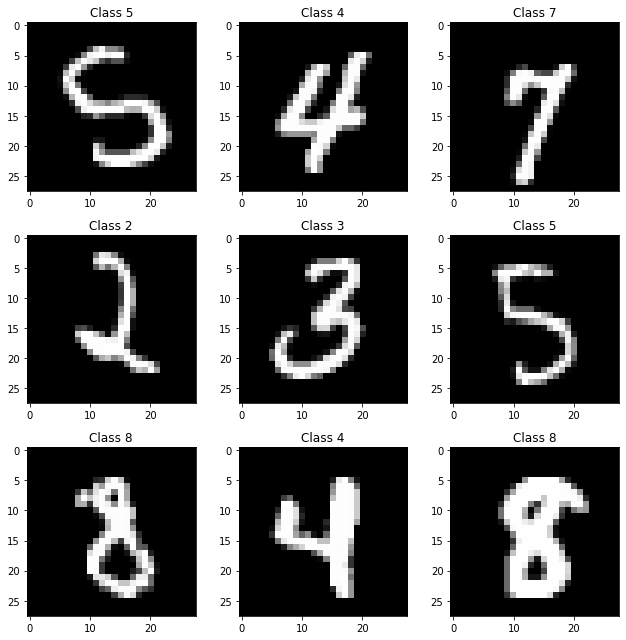

In [ ]:
plt.rcParams['figure.figsize'] = (9,9) # Make the figures a bit bigger

for i in range(9):
    plt.subplot(3,3,i+1)
    num = random.randint(0, len(X_train))
    plt.imshow(X_train[num], cmap='gray', interpolation='none')
    plt.title("Class {}".format(y_train[num]))
    
plt.tight_layout()

한 자릿수를 조금 더 자세히 살펴보고 마지막 자릿수를 나타내는 배열을 출력해 보겠습니다.

손글씨 한 장의 이미지는 28 x 28 = 784개의 픽셀로 이루어져 있습니다.

아래 코드로 픽셀 정보를 눈으로 확인할 수 있습니다.

In [ ]:
# just a little function for pretty printing a matrix
def matprint(mat, fmt="g"):
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
        print("")

# now print!        
matprint(X_train[num])

0  0  0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0  0  0  0  0  0  
0  0  0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0  0  0  0  0  0  
0  0  0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0  0  0  0  0  0  
0  0  0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0  0  0  0  0  0  
0  0  0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0  0  0  0  0  0  
0  0  0  0  0  0  0  0    0    0    0    0  149  254  254  254  254  254  164   41    0    0    0  0  0  0  0  0  
0  0  0  0  0  0  0  0    0    0   46  232  252  253  253  253  253  253  253  250   89    0    0  0  0  0  0  0  
0  0  0  0  0  0  0  0    0   46  166  253  253  253  253  253  253  253  253  253  246  149    0  0  0  0  0  0  
0  0  0  0  0  0  0  0    0  158  253  253  253  253  253  199  253  253  253  2

각 픽셀은 0-255 사이의 8비트 정수입니다. 0은 완전한 검정이고 255는 완전한 흰색입니다. 이것을 단일 채널 픽셀이라고 합니다. 모노크롬이라고 합니다.

*재미있는 사실! 컴퓨터 화면에는 각 픽셀에 대해 빨강, 녹색, 파랑의 세 가지 채널이 있습니다. 이러한 각 채널은 또한 8비트 정수를 사용합니다. 3개 채널 -- 총 24비트 -- 16,777,216가지 색상 가능!*

# Introducing Convolution! What is it?

이전에는 각 값의 정규화된 픽셀 값을 받아들이고 해당 값에 대해서만 작동하는 네트워크를 구축했습니다. 대신 각 이미지의 다른 특징(예: **곡률, 가장자리**)을 네트워크에 제공하고 네트워크에서 이미지 분류에 중요한 특징을 학습하도록 할 수 있다면 어떨까요?

이것은 회선을 통해 가능합니다! 컨볼루션은 각 이미지를 통과하고 **기능 맵**을 생성하는 **커널**(필터)을 적용합니다.

<img src = 'convolution.gif' >

위의 예에서 이미지는 5 x 5 행렬이고 그 위에 있는 커널은 3 x 3 행렬입니다. 이미지와 커널 사이에 내적 연산이 발생하고 컨볼루션 피쳐가 생성됩니다. CNN의 각 커널은 이미지의 다른 특성을 학습합니다.

커널은 사진 편집 소프트웨어에서 흐림, 가장자리 감지, 선명하게 하기 등을 적용하는 데 자주 사용됩니다.

<img src = 'kernels.png' >

딥 러닝 네트워크의 커널은 유사한 방식으로 사용됩니다. 즉, 일부 기능을 강조 표시합니다. **max pooling**이라는 시스템과 결합하여 강조 표시되지 않은 요소는 각 기능 맵에서 삭제되어 관심 있는 기능만 남겨두고 학습된 매개변수의 수를 줄이고 계산 비용(예: 시스템 메모리)을 줄입니다.

<img src = 'max_pooling.png' >

우리는 또한 컨볼루션의 컨볼루션을 사용할 수 있습니다. 커널에 맞는 충분한 픽셀이 있는 한 원하는 만큼 컨볼루션을 쌓을 수 있습니다.

*경고: deep convolutions 에서 찾을 수 있는 내용은 인식할 수 없는 것처럼 보일 수 있습니다.*

<img src = 'go_deeper.jpg' >

## Building a "Deep" Convolutional Neural Network

In [ ]:
# import some additional tools

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, Flatten
from tensorflow.keras.layers import BatchNormalization

In [ ]:
# Reload the MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [ ]:
# Again, do some formatting
# Except we do not flatten each image into a 784-length vector because we want to perform convolutions first

X_train = X_train.reshape(60000, 28, 28, 1) #add an additional dimension to represent the single-channel
X_test = X_test.reshape(10000, 28, 28, 1)

X_train = X_train.astype('float32')         # change integers to 32-bit floating point numbers
X_test = X_test.astype('float32')

X_train /= 255                              # normalize each value for each pixel for the entire vector for each input
X_test /= 255

print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

Training matrix shape (60000, 28, 28, 1)
Testing matrix shape (10000, 28, 28, 1)


In [ ]:
# one-hot format classes

nb_classes = 10 # number of unique digits

Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

In [ ]:
model = Sequential()                                 # Linear stacking of layers

# Convolution Layer 1
model.add(Conv2D(32, (3, 3), input_shape=(28,28,1))) # 32 different 3x3 kernels -- so 32 feature maps
model.add(BatchNormalization(axis=-1))               # normalize each feature map before activation
convLayer01 = Activation('relu')                     # activation
model.add(convLayer01)

# Convolution Layer 2
model.add(Conv2D(32, (3, 3)))                        # 32 different 3x3 kernels -- so 32 feature maps
model.add(BatchNormalization(axis=-1))               # normalize each feature map before activation
model.add(Activation('relu'))                        # activation
convLayer02 = MaxPooling2D(pool_size=(2,2))          # Pool the max values over a 2x2 kernel
model.add(convLayer02)

# Convolution Layer 3
model.add(Conv2D(64,(3, 3)))                         # 64 different 3x3 kernels -- so 64 feature maps
model.add(BatchNormalization(axis=-1))               # normalize each feature map before activation
convLayer03 = Activation('relu')                     # activation
model.add(convLayer03)

# Convolution Layer 4
model.add(Conv2D(64, (3, 3)))                        # 64 different 3x3 kernels -- so 64 feature maps
model.add(BatchNormalization(axis=-1))               # normalize each feature map before activation
model.add(Activation('relu'))                        # activation
convLayer04 = MaxPooling2D(pool_size=(2,2))          # Pool the max values over a 2x2 kernel
model.add(convLayer04)
model.add(Flatten())                                 # Flatten final 4x4x64 output matrix into a 1024-length vector

# Fully Connected Layer 5
model.add(Dense(512))                                # 512 FCN nodes
model.add(BatchNormalization())                      # normalization
model.add(Activation('relu'))                        # activation

# Fully Connected Layer 6                       
model.add(Dropout(0.2))                              # 20% dropout of randomly selected nodes
model.add(Dense(10))                                 # final 10 FCN nodes
model.add(Activation('softmax'))                     # softmax activation

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 26, 26, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 26, 26, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 24, 24, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 24, 24, 32)        0

In [ ]:
# we'll use the same optimizer

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.fit(X_train,Y_train, steps_per_epoch=60000//128, epochs=3, verbose=1, 
                    validation_data=(X_test, Y_test), validation_steps=10000//128)

Epoch 1/3
468/468 [==============================] - 17s 11ms/step - loss: 0.0838 - accuracy: 0.9749 - val_loss: 0.1176 - val_accuracy: 0.9649
Epoch 2/3
468/468 [==============================] - 5s 10ms/step - loss: 0.0294 - accuracy: 0.9913 - val_loss: 0.0383 - val_accuracy: 0.9868
Epoch 3/3
457/468 [============================>.] - ETA: 0s - loss: 0.0227 - accuracy: 0.9930

468/468 [==============================] - 5s 11ms/step - loss: 0.0226 - accuracy: 0.9930 - val_loss: 0.0223 - val_accuracy: 0.9925


In [ ]:
score = model.evaluate(X_test, Y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 1s 4ms/step - loss: 0.0223 - accuracy: 0.9925
Test score: 0.0223393477499485
Test accuracy: 0.9925000071525574


In [ ]:
'''
def prediction(image, model):
    img = cv2.resize(image, (28, 28))
    img = img / 255
    img = img.reshape(1, 28, 28, 1)
    predict = model.predict(img)
    prob = np.amax(predict)
    class_index = model.predict_classes(img)
    result = class_index[0]
    if prob < 0.75:
        result = 0
        prob = 0
    return result, prob
    '''

'\ndef prediction(image, model):\n    img = cv2.resize(image, (28, 28))\n    img = img / 255\n    img = img.reshape(1, 28, 28, 1)\n    predict = model.predict(img)\n    prob = np.amax(predict)\n    class_index = model.predict_classes(img)\n    result = class_index[0]\n    if prob < 0.75:\n        result = 0\n        prob = 0\n    return result, prob\n    '

In [ ]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [ ]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [ ]:
def get_numbers(y_pred):
    for number, per in enumerate(y_pred[0]):
        if per != 0:
            final_number = str(int(number))
            per = round((per * 100), 2)
            return final_number, per

In [ ]:
model.save("mnist.h5")

In [ ]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    frame = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # predict digit on video frame
    img_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    ret,img_binary = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)

    kernel = cv2.getStructuringElement( cv2.MORPH_RECT, ( 5, 5 ) )
    img_binary = cv2.morphologyEx(img_binary, cv2. MORPH_CLOSE, kernel)

    contours, hierarchy = cv2.findContours(img_binary, cv2.RETR_EXTERNAL, 
                            cv2.CHAIN_APPROX_SIMPLE)

    try:
        for contour in contours:

            (x, y), radius = cv2.minEnclosingCircle(contour)
            
            if radius > 10: #noise버리기
                xs, xe = int(x-radius), int(x+radius)
                ys, ye = int(y-radius), int(y+radius)

                img_digit = img_binary[ys:ye, xs:xe]

                kernel = np.ones((5, 5), np.uint8)
                img_digit = cv2.morphologyEx(img_digit, cv2.MORPH_DILATE, kernel)

                #model = load_model('mnist.h5')

                img_digit = cv2.resize(img_digit, (28, 28), interpolation=cv2.INTER_AREA)

                img_digit = img_digit / 255.0

                img_input = img_digit.reshape(1, 28, 28, 1)
                predictions = model.predict(img_input, verbose=0)


                number = np.argmax(predictions)
                #print(number)

                bbox_array= cv2.rectangle(bbox_array, (xs, ys), (xe, ye), (255, 255, 0), 2)


                location = (x, y - 10)
                font = cv2.FONT_HERSHEY_COMPLEX  
                fontScale = 1.2
                bbox_array = cv2.putText(bbox_array, str(number), (xs, ys), font, fontScale, (0,255,0), 2)

    except Exception as e:
            pass

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

<IPython.core.display.Javascript object>